Importing Libraries

In [64]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Extracting the data

In [65]:
df = pd.read_csv('vaccination_tweets.csv')

In [66]:
#Dimensions of the dataset
df.shape


(11020, 16)

In [67]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                11020 non-null  int64 
 1   user_name         11020 non-null  object
 2   user_location     8750 non-null   object
 3   user_description  10340 non-null  object
 4   user_created      11020 non-null  object
 5   user_followers    11020 non-null  int64 
 6   user_friends      11020 non-null  int64 
 7   user_favourites   11020 non-null  int64 
 8   user_verified     11020 non-null  bool  
 9   date              11020 non-null  object
 10  text              11020 non-null  object
 11  hashtags          8438 non-null   object
 12  source            11019 non-null  object
 13  retweets          11020 non-null  int64 
 14  favorites         11020 non-null  int64 
 15  is_retweet        11020 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.2+ MB


Preprocessing the Data

In [69]:
#Checking for NULL values(if any)
df.isnull().sum()

,0
id,0
user_name,0
user_location,2270
user_description,680
user_created,0
user_followers,0
user_friends,0
user_favourites,0
user_verified,0
date,0


In [70]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [71]:
# Dropping unnecessary columns
text_df = df.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'], axis=1)
text_df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [72]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF 

While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm 

#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P 

Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4 

Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq 



In [73]:
# Updated data info
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11020 non-null  object
dtypes: object(1)
memory usage: 86.2+ KB


In [74]:
# Processing the text data
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)  # Removing URL extensions
    text = re.sub(r'\@w+|\#','',text)                                       # Removing @ and #
    text = re.sub(r'[^\w\s]','',text)                                       # Removing special characters
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]         # Removing stop words
    return " ".join(filtered_text)

In [75]:
text_df.text = text_df['text'].apply(data_processing)

In [76]:
# Stemming the words
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [77]:
text_df['text'] = text_df['text'].apply(lambda x: stemming(x))

In [78]:
text_df.head()

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine borisjohnson matthancock ...


In [79]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

folks said daikon paste could treat cytokine storm pfizerbiontech 

world wrong side history year hopefully biggest vaccination effort weve ev 

coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_19 russian vaccine created last 24 years 

facts immutable senator even youre ethically sturdy enough acknowledge 1 born 

explain need vaccine borisjohnson matthancock whereareallthesickpeople pfizerbiontech 



In [80]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11020 non-null  object
dtypes: object(1)
memory usage: 86.2+ KB


Sentiment Analysis of the Data

In [81]:
# Checking the outcome(positive, neutral, negative)
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [82]:

# Creating new column for polarity
text_df['polarity'] = text_df['text'].apply(polarity)

In [83]:
text_df.head(10)

,text,polarity
0,folks said daikon paste could treat cytokine s...,0.000
1,world wrong side history year hopefully bigges...,-0.500
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.000
3,facts immutable senator even youre ethically s...,0.100
4,explain need vaccine borisjohnson matthancock ...,0.000
5,anyone useful adviceguidance whether covid vac...,0.400
6,bit sad claim fame success vaccination patriot...,-0.100
7,many bright days 2020 best 1 bidenharris winni...,0.675
8,covid vaccine getting covidvaccine covid19 pfi...,0.000
9,covidvaccine states start getting covid19vacci...,0.000


In [84]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [85]:
text_df['sentiment'] = text_df['polarity'].apply(sentiment)

In [86]:
text_df.head()

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
1,world wrong side history year hopefully bigges...,-0.5,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Neutral
3,facts immutable senator even youre ethically s...,0.1,Positive
4,explain need vaccine borisjohnson matthancock ...,0.0,Neutral


Visualisation of result

<Axes: xlabel='sentiment', ylabel='count'>

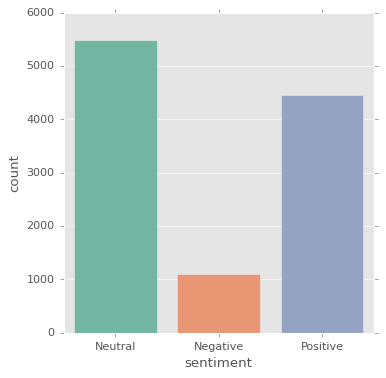

In [87]:
# Plotting the Graph
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data=text_df, palette="Set2")

Text(0.5, 1.0, 'Distribution of sentiments')

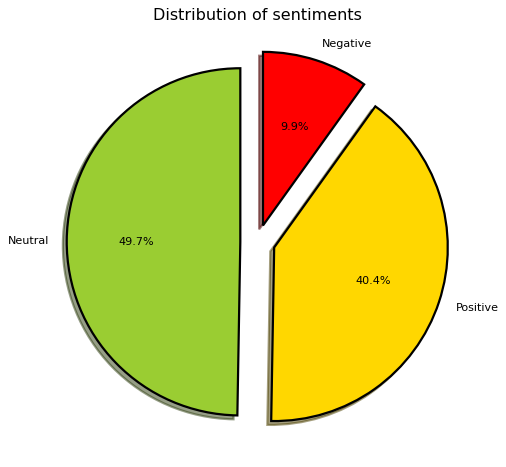

In [88]:
# Plotting a Pie chart
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

Visualisation of each sentiment in word cloud

In [89]:
# Separating the Positive tweets
pos_tweets = text_df[text_df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['polarity'], ascending= False)
pos_tweets.head()

,text,polarity,sentiment
9216,despite israel pfizerbiontech vaccine consider...,1.0,Positive
7859,excellent news israel pfizerbiontech pfizervac...,1.0,Positive
2308,thankful get covid vaccine today impressed org...,1.0,Positive
5534,syappa mukka done dusted best thing happened m...,1.0,Positive
8719,got vaccine todayy hooray gods timing always p...,1.0,Positive


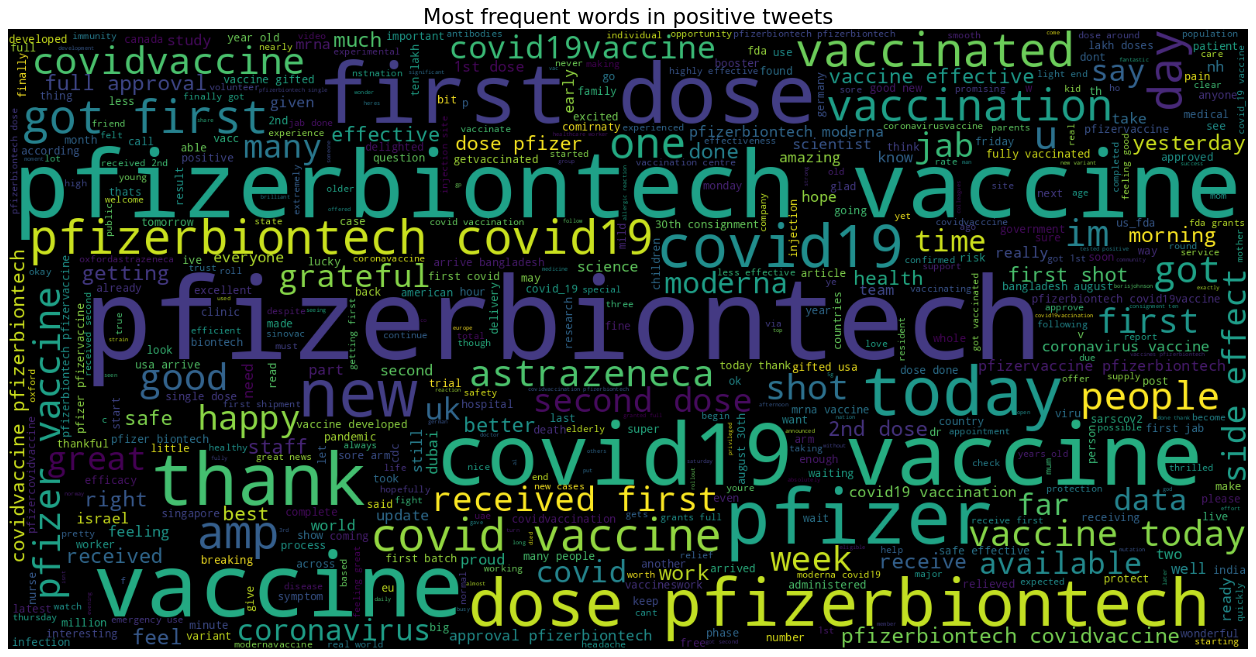

In [90]:
# Displaying the Word Cloud of positive tweets
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [91]:
# Separating the negative tweets
neg_tweets = text_df[text_df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['polarity'], ascending= False)
neg_tweets.head()

,text,polarity,sentiment
2912,work skilled nursing facility got first vaccin...,-0.003333,Negative
7256,200321 752308 vaccinations new daily record da...,-0.003409,Negative
2073,ukgovernment cant even vaccinate properly ethi...,-0.004762,Negative
7715,got first dose less waiting time airport vacci...,-0.005556,Negative
7157,nas_k27 second dose due end next month well fa...,-0.006250,Negative


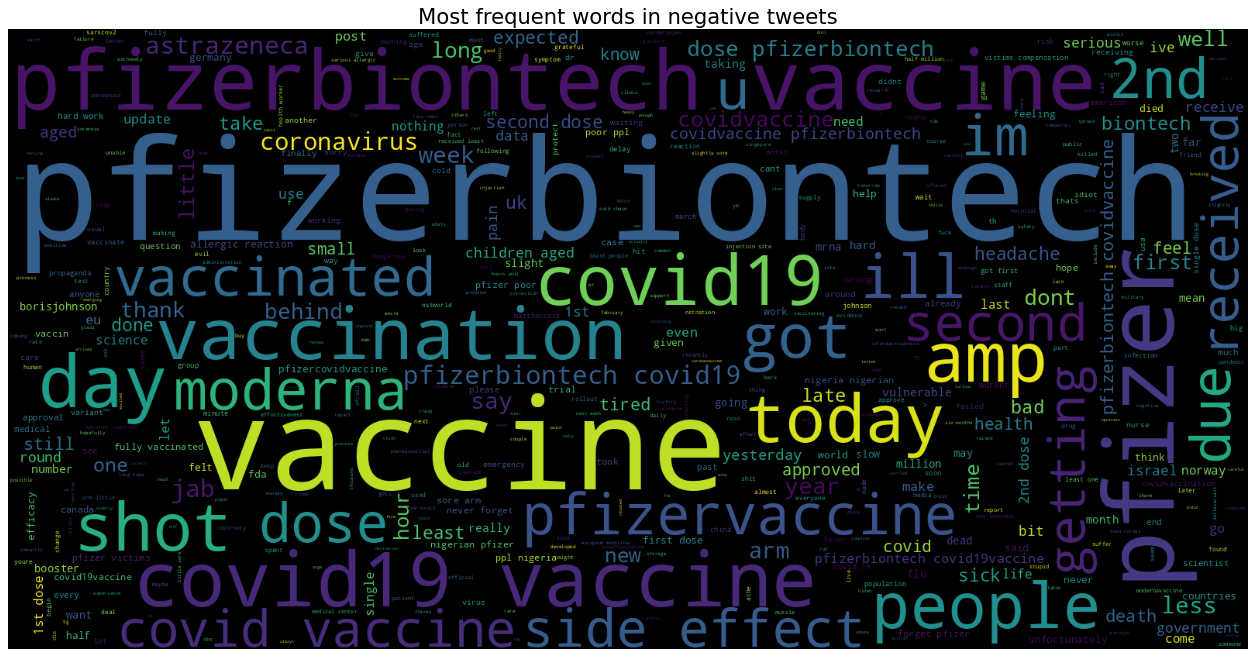

In [92]:
# Displaying the Word Cloud for negative tweets
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

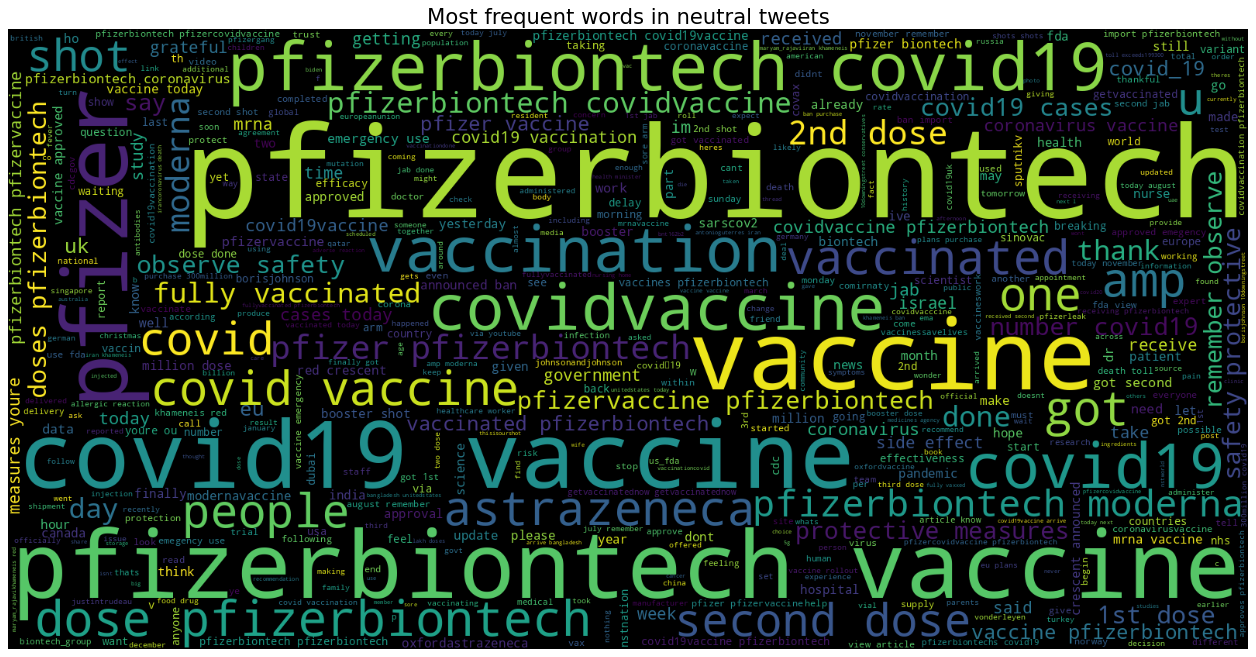

In [93]:
# Separating neutral tweets and displaying word cloud for them
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['polarity'], ascending= False)
text = ' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

Feature Extraction for model Training

In [94]:
# Converting the text to numericals
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['text'])

In [95]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))    # Total number of features found
print("First 20 features:\n {}".format(feature_names[:20]))     # First 20 features

Number of features: 78583

First 20 features:
 ['000' '000 doses' '000 initial' '000 people' '000 vaccines' '0000001'
 '0000001 covid19' '0011' '0011 abt' '004' '004 covid' '004 israelis' '01'
 '01 getting' '01 june' '01 november' '01aug2021' '01aug2021 doublevaxxed'
 '02' '02 175']


In [96]:
# Separating into X and Y for model analysis
X = text_df['text']
Y = text_df['sentiment']
X = vect.transform(X)

Splitting Training and Testing Data

In [97]:
# Separating training and testing data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [98]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (8816, 78583)
Size of y_train: (8816,)
Size of x_test: (2204, 78583)
Size of y_test: (2204,)


Fitting the Model

In [99]:
logreg = LogisticRegression()                           # Applying the logistic regression
logreg.fit(x_train, y_train)                            # Fitting the model for data
logreg_pred = logreg.predict(x_test)                    # Predicting sentiments for X_test
logreg_acc = accuracy_score(logreg_pred, y_test)        # Finding the accuracy score for the predicted and real data
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 85.25%


In [100]:
print(classification_report(y_test, logreg_pred))      # Displaying the Classification report

              precision    recall  f1-score   support

    Negative       0.84      0.31      0.45       218
     Neutral       0.80      0.99      0.88      1087
    Positive       0.95      0.82      0.88       899

    accuracy                           0.85      2204
   macro avg       0.86      0.71      0.74      2204
weighted avg       0.86      0.85      0.84      2204



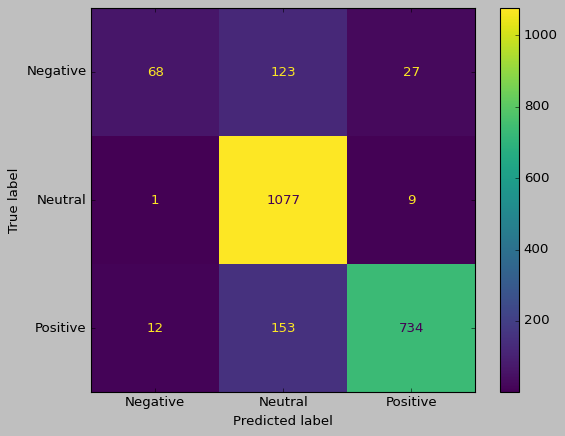

In [101]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)    # Displaying confusion matrix
disp.plot()